## Loading Dataset

In [47]:
import psycopg2
import pandas as pd
import seaborn as sns
from  scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
conn = psycopg2.connect("dbname=musicdatabase")
cur = conn.cursor()

## Creating DataFrames

In [8]:
#GENRES:
cur.execute("SELECT * FROM genres")
names = [description[0] for description in cur.description]
genres = cur.fetchall()
genres_df = pd.DataFrame(genres, columns=names)

# #ARTISTS
cur.execute("SELECT * FROM artists")
names = [description[0] for description in cur.description]
artists = cur.fetchall()
artists_df = pd.DataFrame(artists, columns=names)

# #CONTENT
cur.execute("SELECT * FROM content")
names = [description[0] for description in cur.description]
content = cur.fetchall()
content_df = pd.DataFrame(content, columns=names)

# #LABELS
cur.execute("SELECT * FROM labels")
names = [description[0] for description in cur.description]
labels = cur.fetchall()
labels_df = pd.DataFrame(labels, columns=names)

# #REVIEWS
cur.execute("SELECT * FROM reviews")
names = [description[0] for description in cur.description]
reviews = cur.fetchall()
reviews_df = pd.DataFrame(reviews, columns=names)

# #YEARS
cur.execute("SELECT * FROM years")
names = [description[0] for description in cur.description]
years = cur.fetchall()
years_df = pd.DataFrame(years, columns=names)

## Exploring the Data

In [9]:
print('genre df length: ', len(genres_df))
print('artists df length: ', len(artists_df))
print('content df length: ', len(content_df))
print('labels df length: ', len(labels_df))
print('reviews df length: ', len(reviews_df))
print('years df length: ', len(years_df))

genre df length:  22680
artists df length:  18831
content df length:  18393
labels df length:  20190
reviews df length:  18393
years df length:  19108


In [10]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18393 non-null object
artist            18393 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


In [11]:
reviews_df.isna().sum()
#no NANs in column 1.. however 2367 in column 2

reviewid             0
title                0
artist               0
url                  0
score                0
best_new_music       0
author               0
author_type       3906
pub_date             0
pub_weekday          0
pub_day              0
pub_month            0
pub_year             0
dtype: int64

## Scratch Work & More Review

In [12]:
reviews_df['author'].value_counts()
reviews_df['author'].nunique()

432

In [13]:
reviews_df['artist'].value_counts().head()

various artists     688
guided by voices     23
the beatles          21
david bowie          21
of montreal          20
Name: artist, dtype: int64

In [14]:
len(set(reviews_df['reviewid']))
#reviews_df['reviewid'].nunique()  #does the same thing

18389

## Seeing Which Tables Have Multiple Rows Per Song

In [15]:
genres_df.loc[genres_df['reviewid'] == 11733]
#example, song 6523 has 4 artists

,reviewid,genre
15417,11733,rock
15418,11733,global
15419,11733,experimental
15420,11733,electronic


* Review Table -- has 4 songs that have 2 reviewid's... i believe this is an error as all rows are identical
* Content Table -- also has 4 songs with 2 reviewid's... will remove the duplicated rows
* Genres Tabel -- Many songs have 2+ genres
* Labels Tabel -- Many songs have 2+ labels
* Artists Tabel -- Many songs have 2+ artists
* Year Tabel -- Many songs have 2+ release years... this may be an error... considering keeping only oldest year

In [16]:
genres_df['reviewid'].value_counts().head(10)

11733    4
21701    4
7683     4
757      4
12222    4
14812    4
12625    4
22465    4
9530     4
9036     4
Name: reviewid, dtype: int64

## Combining Genre and Review Tables

First, one hot encode genres table. 

In [17]:
# genres_df['pop/r&b'] = genres_df['genre'].apply(lambda x: 1 if x == 'pop/r&b' else 0)
# genres_df['electronic'] = genres_df['genre'].apply(lambda x: 1 if x == 'electronic' else 0)

In [18]:
genres_one_hot = pd.get_dummies(genres_df['genre'])
genres_one_hot.head()
genres_hot_df = pd.concat([genres_df, genres_one_hot], axis = 1)
genres_hot_df.head()

,reviewid,genre,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock
0,22703,electronic,1,0,0,0,0,0,0,0,0
1,22721,metal,0,0,0,0,0,1,0,0,0
2,22659,rock,0,0,0,0,0,0,0,0,1
3,22661,rock,0,0,0,0,0,0,0,0,1
4,22725,electronic,1,0,0,0,0,0,0,0,0


Second, filtered genres table for only pop & electric

In [19]:
genres_hot_df_filtered = genres_hot_df[(genres_hot_df['pop/r&b'] == 1) | (genres_hot_df['electronic'] == 1)]
genres_hot_df_filtered = genres_hot_df_filtered[['reviewid', 'electronic', 'pop/r&b']]
genres_hot_df_filtered.head()

,reviewid,electronic,pop/r&b
0,22703,1,0
4,22725,1,0
7,22694,1,0
12,22700,1,0
18,22719,0,1


Third, add value_count column in order to remove any albums that fall under both electronic & pop.

In [20]:
z = genres_hot_df_filtered['reviewid'].value_counts()
z1 = z.to_dict()
genres_hot_df_filtered['value_count'] = genres_hot_df_filtered['reviewid'].apply(lambda x: z1[x])
genres_hot_df_filtered.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Remove albums with both electronic and pop (where value_counts = 2)

In [21]:
to_drop = genres_hot_df_filtered[genres_hot_df_filtered['value_count'] == 2]
genres_df = genres_hot_df_filtered.drop(to_drop.index, axis=0)
genres_df.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Merge the new Genre Table with the existing Review Table

In [54]:
#rg = review & genres
rg_df = reviews_df.merge(genres_df, left_on='reviewid', right_on='reviewid')
rg_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,electronic,pop/r&b,value_count
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,1,0,1
1,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,1,0,1
2,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,5,1,2017,1,0,1
3,22700,nadir,steven warwick,http://pitchfork.com/reviews/albums/22700-nadir/,7.6,0,thea ballard,contributor,2017-01-03,1,3,1,2017,1,0,1
4,22719,merry christmas lil mama,"chance the rapper, jeremih",http://pitchfork.com/reviews/albums/22719-merr...,8.1,0,sheldon pearce,associate staff writer,2016-12-30,4,30,12,2016,0,1,1


#### Hypothesis Test #1 
* Null: There is no statistically significant difference between the reviews for pop/R&B albums and electronic music albums.
* Alternative: The reviews for pop/R&B albums and electronic albums have a statistically significant difference between how they are reviewed, either positively or negatively. 

In [23]:
pop_df = rg_df[rg_df['pop/r&b'] == 1].copy()
elec_df = rg_df[rg_df['electronic'] == 1].copy()

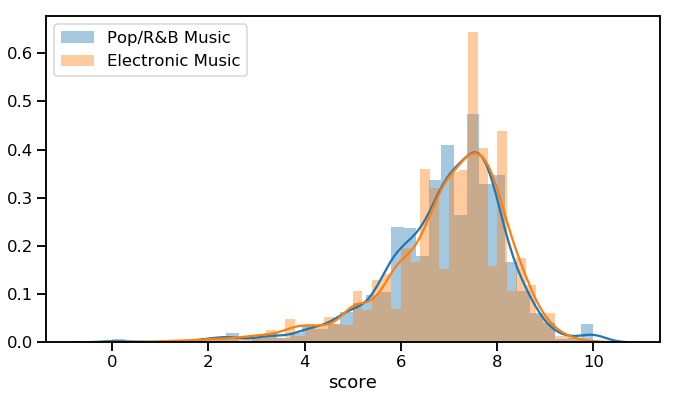

In [43]:
plt.figure(figsize=(11,6))
sns.distplot(pop_df['score'], label="Pop/R&B Music")
sns.distplot(elec_df['score'], label="Electronic Music");
plt.legend();

In [44]:
pop_df['score'].mean() - elec_df['score'].mean()

-0.01573202690610831

In [52]:
t_stat, p_val = ttest_ind(pop_df['score'],elec_df['score'])
print(f"T-Statistic: {t_stat}\nP-Value: {p_val}")

T-Statistic: -0.36421091026425517
P-Value: 0.7157164040794012
